In [1]:
# %pip uninstall boardlib
%pip install boardlib
# %pip install pandas
# %pip install pandasgui
# Download the kilter dataset by running this in the terminal:
# boardlib database kilter ./kilter.db

Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 24.2 -> 24.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import sqlite3
import boardlib
import pandas as pd
from pandasgui import show
import matplotlib.pyplot as plt
import scipy.sparse as sp
import numpy as np
import importlib

from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset

In [3]:
import importlib
import sys

# Delete all submodules from sys.modules to force a full reload
submodules = [
    'MyPackage.embeddings',
    'MyPackage.process',
    'MyPackage.visualize',
    'MyPackage.markov',
    
]

for submodule in submodules:
    if submodule in sys.modules:
        del sys.modules[submodule]

import MyPackage.process
import MyPackage.visualize
import MyPackage.markov
import MyPackage.embeddings

importlib.reload(MyPackage.process)
importlib.reload(MyPackage.visualize)
importlib.reload(MyPackage.markov)
importlib.reload(MyPackage.embeddings)

from MyPackage.embeddings import *
from MyPackage.process import *
from MyPackage.visualize import *
from MyPackage.markov import *


print("All functions and classes have been reloaded and imported.")
from MyPackage.process import benchmark3, benchmark4


[14. 14.]
[[-0.76 -0.65]
 [ 0.68 -0.74]]
[0.8]
[14. 14.]
[[-0.76 -0.65]
 [ 0.68 -0.74]]
[0.8]
All functions and classes have been reloaded and imported.


### Creating SQL Database Connection and Converting tables to dfs ###

In [4]:

con = sqlite3.connect('kilter.db')
cur = con.cursor()
table_list = [a for a in cur.execute("SELECT name FROM sqlite_master WHERE type = 'table'")]
table_names = [entry[0] for entry in table_list]
table_names.sort()
print(table_names)
con.close()

def table_to_df(table_name):
    con = sqlite3.connect('kilter.db')

    df =  pd.read_sql_query(f"SELECT * FROM {table_name}", con)
    
    con.close()

    return df

# get all tables as dfs
for table_name in table_names:
    globals()[table_name] = table_to_df(table_name)
# print("The available dataframes are: \n\t" + "\n\t".join(table_names))

['android_metadata', 'ascents', 'attempts', 'beta_links', 'bids', 'circuits', 'circuits_climbs', 'climb_cache_fields', 'climb_random_positions', 'climb_stats', 'climbs', 'difficulty_grades', 'holes', 'kits', 'layouts', 'leds', 'placement_roles', 'placements', 'product_sizes', 'product_sizes_layouts_sets', 'products', 'products_angles', 'sets', 'shared_syncs', 'tags', 'user_permissions', 'user_syncs', 'users', 'walls', 'walls_sets']


### Create Filtered DF with Merged Tables

In [5]:
# print(globals()['ascents'].head().to_string(index=False)) #for printing head of table

def merge_filter_climbs(climbs, climb_stats):
    merged_df = pd.merge(climbs, climb_stats, left_on='uuid', right_on='climb_uuid', how='inner')
    merged_df = merged_df[merged_df['layout_id'] == 1]
    
    # Remove rows with 2 or less ascensionists
    merged_df = merged_df[merged_df['ascensionist_count'] >= 1]  # about 101629 climbs

    merged_df['vgrade'] = merged_df['display_difficulty'].apply(map_vgrade)

    filtered_columns = ['name','vgrade','angle_y','display_difficulty','created_at', 'ascensionist_count','frames','fa_username', 'benchmark_difficulty',  'is_draft',  'climb_uuid']
    filtered_df = merged_df.loc[:, filtered_columns]
    
    filtered_df = filtered_df.drop_duplicates(subset=['name'])
    
    filtered_df['hold_count'] = filtered_df['frames'].str.count('p')

    filtered_df = filtered_df[filtered_df['hold_count'] <=21] # 21 is about 100649 climbs
    return filtered_df

climbs = globals()['climbs']
climb_stats=globals()['climb_stats']
filtered_df = merge_filter_climbs(climbs, climb_stats)

print("Number of climbs:", filtered_df.shape[0])

Number of climbs: 100649


### Some Graphs

In [6]:
# plot_vgrade_counts(filtered_df)
# plot_hold_counts(filtered_df)
# average_starting_hold_height, percentage_with_starting_holds_at_35 = analyze_starting_hold_heights(filtered_df)
# print_unique_climbs_count(filtered_df)


### Create Text File

In [7]:
filtered_df = filter_climbs(filtered_df, vgrade=-1, angle=-1)
# filtered_df['frames'] = filtered_df['frames'].apply(lambda x: sort_frame(x, handedness=False))
filtered_df['frames'] = filtered_df['frames'].apply(sort_frame_4)
filtered_df_to_text_file(filtered_df, file_path='climbs.txt')



file_path = 'climbs.txt'

# def print_unique_words(file_path):
#     word_counts = count_unique_words(file_path)
#     if word_counts:
#         sorted_word_counts = sorted(word_counts.items(), key=lambda item: item[0], reverse=True)
#         for word, count in sorted_word_counts:
#             print(word, count)


### Markov Chain Model

In [8]:
from collections import defaultdict
import string
import random
from collections import defaultdict, Counter
class Markov():
    def __init__(self, file_path):
        self.file_path = file_path
        self.text = self.remove_punctuations(self.get_text())
        self.model = self.model()

    def get_text(self):
        text = []
        for line in open(self.file_path):
            text.append(line)
        return ' '.join(text)
    
    def remove_punctuations(self, text):
        return text.translate(str.maketrans('','', string.punctuation))
    
    def model(self):
        # split the input text into individual words seperated by spaces
        words = self.text.split(' ')
        markov_dict = defaultdict(list)
        # create list of all word pairs
        for current_word, next_word in zip(words[0:-1], words[1:]):
            markov_dict[current_word].append(next_word)
        markov_dict = dict(markov_dict)
        print('Successfully Trained')
        return markov_dict
    
def predict_words(chain, first_word, number_of_words):
    if first_word in list(chain.keys()):
        word1 = str(first_word)
        predictions = word1.capitalize()
        # Generate the second word from the value list. Set the new word as the first word. Repeat.
        for i in range(number_of_words):
            if word1 not in chain:
                break
            next_words = chain[word1]
            word_counts = Counter(next_words)
            total_count = sum(word_counts.values())
            probabilities = {word: count / total_count for word, count in word_counts.items()}

            # Print the probabilities
            print(f"Current word: {word1}")
            print("Next word probabilities:")
            for word, prob in probabilities.items():
                print(f"  {word}: {prob:.2f}")

            # Choose the next word based on the probabilities
            word2 = random.choices(list(probabilities.keys()), weights=probabilities.values())[0]
            word1 = word2
            predictions += ' ' + word2
        return predictions
    else:
        return "Word not in corpus"
    
def is_valid_sequence(sequence):
    # Count the number of start holds (r12) and finish holds (r14)
    start_hold_count = sequence.count('r12')
    finish_hold_count = sequence.count('r14')

    # Check if the counts are within the specified range
    return 1 <= start_hold_count <= 2 and 1 <= finish_hold_count <= 2

def predict_valid_sequence(chain, start_hold, number_of_words):
    while True:
        # Generate a sequence of words using the Markov chain model
        sequence = predict_words(chain, start_hold, number_of_words)
        
        # Convert the sequence to a string
        sequence_str = ' '.join(sequence.split())
        # Check if the sequence is valid
        if is_valid_sequence(sequence_str):
            return sequence_str

Successfully Trained
Current word: 1081r15
Next word probabilities:
  : 1.00
Current word: 
Next word probabilities:
  1142r12: 0.00
  1179r12: 0.00
  1141r15: 0.00
  1144r15: 0.00
  1464r15: 0.00
  1461r15: 0.00
  1192r13: 0.00
  1246r13: 0.00
  1260r13: 0.00
  1247r15: 0.00
  1294r13: 0.00
  1331r13: 0.00
  1382r14
: 0.00
  1234r12: 0.00
  1544r15: 0.00
  1539r15: 0.00
  1236r12: 0.00
  1521r15: 0.00
  1517r15: 0.00
  1494r15: 0.00
  1499r15: 0.00
  1476r15: 0.00
  1103r15: 0.00
  1252r14
: 0.00
  1168r12: 0.00
  1187r12: 0.00
  1151r15: 0.00
  1137r15: 0.00
  1100r15: 0.00
  1220r13: 0.00
  1178r15: 0.00
  1253r13: 0.00
  1192r15: 0.00
  1197r15: 0.00
  1200r15: 0.00
  1268r13: 0.00
  1265r13: 0.00
  1278r14
: 0.00
  1151r12: 0.00
  1153r12: 0.00
  1073r15: 0.00
  1453r15: 0.00
  1255r13: 0.00
  1173r15: 0.00
  1258r13: 0.00
  1339r14
: 0.00
  1136r12: 0.00
  1457r15: 0.00
  1449r15: 0.00
  1186r13: 0.00
  1145r15: 0.00
  1198r13: 0.00
  1284r13: 0.01
  1283r13: 0.01
  1557r15: 0.00

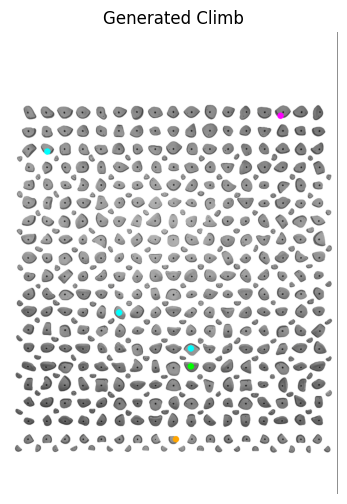

In [9]:
m = Markov(file_path='climbs.txt')
chain = m.model

valid_sequence = predict_valid_sequence(chain, '1081r15', number_of_words=13)
def frame_to_image(frame):
    image_path = "KilterBoardSetup.png"
    coords_list = frame_to_imagecoords(frame)
    print(coords_list)
    draw_colored_circles_on_image(image_path, coords_list)
print("Valid Sequence:", valid_sequence)
generated_frame = 'p' + valid_sequence.replace(' ', 'p')
print("Benchmark: ", benchmark4(generated_frame, row_weight=0.1))
frame_to_image(generated_frame)

# r12 - starthold  
# r13 - hand hold  
# r14 - finish hold 
# r15 - foot hold   


In [10]:
def ids_to_coordinates():
    # Iterate through the first range: 1073-1395
    for id in range(1073, 1396):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")
    
    # Iterate through the second range: 1447-1599
    for id in range(1447, 1600):
        coord = id_to_coordinate(id)
        # print(f"ID {id} converted to coordinates: {coord}")

ids_to_coordinates()

In [11]:
print(len(filtered_df))

98951


### Prepare Data into npz file ###

In [12]:
def climb_to_tupleslist(row):
    frames = row['frames']
    climb_angle = row['angle_y']
    climb_difficulty = map_vgrade(row['display_difficulty'])

    triplets = frame_to_triplets(frames)
    hold_ids =  frame_to_ids(frames)[0]
    feature_tuples = []

    for i, (x, y, val) in enumerate(triplets):
        hold_direction, hold_quality = get_hold_vector(y, x)
        hold_index2 = id_to_index2(hold_ids[i])
        hold_class_id = id_to_class_id(hold_ids[i])
        val_class_id = val
        hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

        # Check if hold_direction is a list of lists and average if necessary
        if isinstance(hold_direction[0], list):  
            hold_direction = average_unit_vectors(hold_direction)

        hold_angle = unit_vector_to_cos(hold_direction)
        modified_quality = modified_hold_quality(climb_angle, hold_quality)
        

        if i < len(triplets) - 1:
            next_x, next_y, _ = triplets[i + 1]
            inter_hold_angle = np.sin(interhold_angle((x, y), (next_x, next_y)))
        else:
            inter_hold_angle = 0  # Last hold doesn't have a next hold
        
        feature_tuple = (int(y), int(x), int(val) , int(hold_index2), int(hold_val_class_id), hold_angle, hold_quality)
        
        # Validate feature_tuple elements
        for j, feature in enumerate(feature_tuple):
            if not isinstance(feature, (int, float)):
                raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
        
        feature_tuples.append(feature_tuple)
    
    return feature_tuples

def df_to_npz(df, filename, num_climbs=None, random_climbs=False):
    climb_matrices = {}

    if num_climbs is not None and num_climbs != "all":
        if random_climbs:
            df = df.sample(n=num_climbs)
        else:
            df = df.head(num_climbs)

    for idx, row in df.iterrows():
        climb_name = row['name']
        feature_tuples = climb_to_tupleslist(row)

        matrix = np.array([list(t) for t in feature_tuples])
        climb_matrices[climb_name] = matrix

    np.savez_compressed(filename, **climb_matrices)

df_to_npz(filtered_df, 'climb_matrices.npz', num_climbs=40000, random_climbs=True)


def load_npz(file):
    data = np.load(file, allow_pickle=True)
    matrices = {key: data[key] for key in data}
    return matrices

def calculate_global_stats(matrices):
    all_data = np.concatenate([matrix for matrix in matrices.values()])
    global_means = np.mean(all_data, axis=0)
    global_stds = np.std(all_data, axis=0)

    # Avoid division by zero
    global_stds[global_stds == 0] = 1

    return global_means, global_stds


def standardize_matrix(matrix, global_means, global_stds):
    standardized_matrix = np.copy(matrix)
    standardized_matrix[:, [0, 1, 5, 6]] = (matrix[:, [0, 1, 5, 6]] - global_means[[0, 1, 5, 6]]) / global_stds[[0, 1, 5, 6]]
    return standardized_matrix


def standardize_npz(input_file, output_file):
    matrices = load_npz(input_file)
    global_means, global_stds = calculate_global_stats(matrices)
    print(global_means)
    
    standardized_matrices = {}
    for climb_name, matrix in matrices.items():
        standardized_matrix = standardize_matrix(matrix, global_means, global_stds)
        standardized_matrices[climb_name] = standardized_matrix
    
    np.savez_compressed(output_file, **standardized_matrices)
    return global_means, global_stds

# Example usage:
global_means, global_stds = standardize_npz('climb_matrices.npz', 'standardized_climb_matrices.npz')

def load_npz(file):
    data = np.load(file, allow_pickle=True)
    matrices = {key: data[key] for key in data}
    return matrices

# Load the climb matrices
climb_matrices = load_npz('climb_matrices.npz')

# Get a list of climb names
climb_names = list(climb_matrices.keys())

# Select a random climb name
random_climb_name = random.choice(climb_names)

# Get the corresponding climb matrix
random_climb_matrix = climb_matrices[random_climb_name]

# Print the climb name
print(f"Random climb name: {random_climb_name}")

# Print the tuple list
print("Tuple list:")
for feature_tuple in random_climb_matrix:
    print(tuple(feature_tuple))

def hold_to_tuple(index2, val,):
    # Convert the hold string to triplets (it will return a list with a single triplet)
    hold_id = index2_to_id(int(index2))
    hold_class_id = id_to_class_id(hold_id)
    x, y = id_to_coordinate(hold_id)

    val_class_id = val
    hold_val_class_id = ids_to_hold_val_class_id(hold_class_id, val_class_id)

    # Get hold direction and hold quality
    hold_direction, hold_quality = get_hold_vector(y, x)
    
    # Check if hold_direction is a list of lists and average if necessary
    if isinstance(hold_direction[0], list):
        hold_direction = average_unit_vectors(hold_direction)

    hold_angle = unit_vector_to_cos(hold_direction)
    
    feature_tuple = (int(y), int(x), int(val_class_id), int(index2), int(hold_val_class_id), hold_angle, hold_quality)
    
    # Validate feature_tuple elements
    for j, feature in enumerate(feature_tuple):
        if not isinstance(feature, (int, float)):
            raise ValueError(f"Invalid feature type at index {j}: {type(feature)}")
    return feature_tuple


[ 1.72750314e+01  1.70016715e+01  1.63233566e+00  2.40588099e+02
  9.01544747e+02 -4.44876594e-03  5.92041030e-01]
Random climb name: dirty little rat crimp
Tuple list:
(10.0, 19.0, 0.0, 147.0, 376.0, 0.039968038348871485, 0.9)
(10.0, 21.0, 0.0, 148.0, 380.0, 0.13019543984976206, 0.9)
(1.0, 17.0, 3.0, 26.0, 35.0, 6.123233995736766e-17, 0.2)
(16.0, 19.0, 1.0, 225.0, 581.0, -0.07974522228288994, 0.6)
(20.0, 15.0, 1.0, 275.0, 709.0, -0.029986509105670932, 0.5)
(17.0, 26.0, 3.0, 239.0, 1643.0, -0.5707710617518374, 0.2)
(24.0, 21.0, 1.0, 330.0, 857.0, -0.05255883312276362, 0.6)
(27.0, 20.0, 1.0, 368.0, 1817.0, 6.123233995736766e-17, 0.2)
(30.0, 23.0, 1.0, 409.0, 1065.0, 0.029986509105671053, 0.6)
(31.0, 20.0, 1.0, 420.0, 1889.0, -0.3401360816544382, 0.2)
(34.0, 23.0, 2.0, 470.0, 1270.0, -0.14002100472618154, 0.8)


### RNN Model ###

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
import numpy as np
import matplotlib.pyplot as plt
import torch.nn.utils.parametrizations as weight_norm
import torch.nn.init as init
import torch.nn.functional as F

# Check if CUDA is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class ClimbDataset(Dataset):
    def __init__(self, npz_file):
        self.data = np.load(npz_file, allow_pickle=True)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        climb_name = list(self.data.keys())[idx]
        climb_matrix = self.data[climb_name]
        row_labels = climb_matrix[:, 0].astype(int)
        col_labels = climb_matrix[:, 1].astype(int)
        hold_class_labels = climb_matrix[:, 3].astype(int)
        val_labels = climb_matrix[:, 2].astype(int)
        angle_labels = climb_matrix[:, 5].astype(float)
        return climb_matrix, row_labels, col_labels, hold_class_labels, val_labels, angle_labels

class SequenceDataset(Dataset):
    def __init__(self, dataset):
        self.sequences, self.row_labels, self.col_labels, self.hold_class_labels, self.val_labels, self.angle_labels = self.extract_sequences(dataset)

    def extract_sequences(self, dataset):
        sequences = []
        row_labels = []
        col_labels = []
        hold_class_labels = []
        val_labels = []
        angle_labels = []
        angle_labels = []

        for i in range(len(dataset)):
            climb_matrix, row_ids, col_ids, hold_class_ids, vals, angles = dataset[i]
            for j in range(1, len(climb_matrix)):
                sequence = climb_matrix[:j]
                row_label = row_ids[j]
                col_label = col_ids[j]
                hold_class_label = hold_class_ids[j]
                val_label = vals[j]
                angle_label = angles[j]
                sequences.append(sequence)
                row_labels.append(row_label)
                col_labels.append(col_label)
                hold_class_labels.append(hold_class_label)
                val_labels.append(val_label)
                angle_labels.append(angle_label)
        return sequences, row_labels, col_labels, hold_class_labels, val_labels, angle_labels

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        sequence = torch.tensor(self.sequences[idx], dtype=torch.float32)
        row_label = self.row_labels[idx]
        col_label = self.col_labels[idx]
        hold_class_label = self.hold_class_labels[idx]
        val_label = self.val_labels[idx]
        angle_label = self.angle_labels[idx]
        return sequence, row_label, col_label, hold_class_label, val_label, angle_label


class RNN(nn.Module):
    def __init__(self, input_size=7, hidden_size=128, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        
        # Initialize LSTM weights
        for name, param in self.rnn.named_parameters():
            if 'weight' in name:
                init.orthogonal_(param)
            elif 'bias' in name:
                init.constant_(param, 0)
        
        # Task-specific layers
        self.fc_row = nn.Linear(hidden_size, 35)  # Predict 35 values for row
        self.fc_col = nn.Linear(hidden_size, 35)  # Predict 35 values for col
        self.fc_hold_class = nn.Linear(hidden_size, 476)  # Predict 476 values for hold class
        self.fc_val = nn.Linear(hidden_size, 4)  # Predict 4 values for val
        self.fc_angle = nn.Linear(hidden_size, 1)  

        # Initialize FC layer weights
        init.xavier_uniform_(self.fc_row.weight)
        init.constant_(self.fc_row.bias, 0)
        
        init.xavier_uniform_(self.fc_col.weight)
        init.constant_(self.fc_col.bias, 0)

        init.xavier_uniform_(self.fc_hold_class.weight)
        init.constant_(self.fc_hold_class.bias, 0)

        init.xavier_uniform_(self.fc_val.weight)
        init.constant_(self.fc_val.bias, 0)

        init.xavier_uniform_(self.fc_angle.weight)         # Initialize angle prediction layer
        init.constant_(self.fc_angle.bias, 0)
        
        
    def forward(self, x, lengths, h0=None, c0=None):
        lengths = lengths.cpu().long()  # Ensure lengths tensor is on CPU and of type int64
        packed_input = pack_padded_sequence(x, lengths, batch_first=True, enforce_sorted=False)
        
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        if c0 is None:
            c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        
        packed_output, (hn, cn) = self.rnn(packed_input, (h0, c0))
        
        out, _ = pad_packed_sequence(packed_output, batch_first=True)
        
        # Get the output of the last time step
        out = out[torch.arange(out.size(0)), lengths - 1]
        
        row_pred = self.fc_row(out)
        col_pred = self.fc_col(out)
        hold_class_pred = self.fc_hold_class(out)
        val_pred = self.fc_val(out)
        angle_pred = self.fc_angle(out)
        
        return row_pred, col_pred, hold_class_pred, val_pred, angle_pred, hn, cn

def collate_fn(batch):
    sequences = [seq for seq, _, _, _, _, _ in batch]
    row_labels = torch.tensor([row_label for _, row_label, _, _, _, _ in batch], dtype=torch.long)
    col_labels = torch.tensor([col_label for _, _, col_label, _, _, _ in batch], dtype=torch.long)
    hold_class_labels = torch.tensor([hold_class_label for _, _, _, hold_class_label, _, _ in batch], dtype=torch.long)
    val_labels = torch.tensor([val_label for _, _, _, _, val_label, _ in batch], dtype=torch.long)
    angle_labels = torch.tensor([angle_label for _, _, _, _, _, angle_label in batch], dtype=torch.float32)
    lengths = torch.tensor([len(seq) for seq in sequences])

    padded_sequences = pad_sequence(sequences, batch_first=True, padding_value=0)

    return padded_sequences, lengths, row_labels, col_labels, hold_class_labels, val_labels, angle_labels
# def calculate_expected_euclidean_distance_topk(hold_pred_logits, actual_hold_id, id_to_coordinate_func, device, k=10):
#     """
#     Calculate the Expected Euclidean Distance (EED) between the top-k predicted hold distributions and actual hold positions.
    
#     Args:
#         hold_pred_logits (torch.Tensor): Logits for hold_id predictions (batch_size x num_holds).
#         actual_hold_id (torch.Tensor): Actual hold_id labels (batch_size).
#         id_to_coordinate_func (function): Function to convert hold_id to (x, y) coordinates.
#         device (torch.device): Device to perform calculations on.
#         k (int): The number of top-k predictions to consider.
        
#     Returns:
#         torch.Tensor: Average EED for the batch.
#     """
#     batch_size, num_holds = hold_pred_logits.size()
    
#     # Step 1: Apply Softmax to get probability distributions
#     P_hold = F.softmax(hold_pred_logits, dim=1)  # Shape: (batch_size, num_holds)
    
#     # Step 2: Get the top-k probabilities and their indices (hold IDs)
#     topk_probs, topk_indices = torch.topk(P_hold, k=k, dim=1)  # Shape: (batch_size, k)
    
#     # Step 3: Convert the top-k hold IDs to (x, y) coordinates
#     # Convert top-k indices to coordinates using the id_to_coordinate function
#     with torch.no_grad():
#         topk_coordinates = torch.tensor([id_to_coordinate_func(hold_id.item()) for hold_ids in topk_indices for hold_id in hold_ids], device=device, dtype=torch.float32)
    
#     # Reshape topk_coordinates to (batch_size, k, 2)
#     topk_coordinates = topk_coordinates.view(batch_size, k, 2)
    
#     # Step 4: Get actual hold coordinates
#     actual_coordinates = torch.tensor([id_to_coordinate_func(hold_id.item()) for hold_id in actual_hold_id], device=device, dtype=torch.float32)  # Shape: (batch_size, 2)
    
#     # Step 5: Expand dimensions to compute pairwise differences
#     # actual_coordinates: (batch_size, 1, 2)
#     actual_coordinates = actual_coordinates.unsqueeze(1)  # Shape: (batch_size, 1, 2)
    
#     # Step 6: Compute Euclidean distances between top-k predicted holds and the actual holds
#     distances = torch.norm(topk_coordinates - actual_coordinates, dim=2)  # Shape: (batch_size, k)
    
#     # Step 7: Compute Expected Euclidean Distance for the top-k holds
#     # Multiply distances by top-k probabilities and sum over the top-k holds
#     expected_distances = torch.sum(topk_probs * distances, dim=1)  # Shape: (batch_size)
    
#     # Step 8: Return the average EED across the batch
#     return expected_distances.mean()

# def calculate_expected_euclidean_distance(hold_pred_logits, actual_hold_id, id_to_coordinate_func, device):
#     """
#     Calculate the Expected Euclidean Distance (EED) between predicted hold distributions and actual hold positions.
    
#     Args:
#         hold_pred_logits (torch.Tensor): Logits for hold_id predictions (batch_size x num_holds).
#         actual_hold_id (torch.Tensor): Actual hold_id labels (batch_size).
#         id_to_coordinate_func (function): Function to convert hold_id to (x, y) coordinates.
#         device (torch.device): Device to perform calculations on.
        
#     Returns:
#         torch.Tensor: Average EED for the batch.
#     """
#     batch_size, num_holds = hold_pred_logits.size()
    
#     # Step 1: Apply Softmax to get probability distributions
#     P_hold = F.softmax(hold_pred_logits, dim=1)  # Shape: (batch_size, num_holds)
    
#     # Step 2: Convert all hold_ids to (x, y) coordinates
#     # Create a tensor of hold_ids from 0 to num_holds-1
#     hold_ids = torch.arange(num_holds, device=device).long()  # Shape: (num_holds)
    
#     # Convert hold_ids to coordinates
#     with torch.no_grad():
#         # Apply the id_to_coordinate function to all hold_ids
#         coordinates = torch.tensor([id_to_coordinate_func(hold_id.item()) for hold_id in hold_ids], device=device, dtype=torch.float32)  # Shape: (num_holds, 2)
    
#     # Step 3: Get actual hold coordinates
#     actual_coordinates = torch.tensor([id_to_coordinate_func(hold_id.item()) for hold_id in actual_hold_id], device=device, dtype=torch.float32)  # Shape: (batch_size, 2)
    
#     # Step 4: Expand dimensions to compute pairwise differences
#     # predicted_coordinates: (1, num_holds, 2)
#     predicted_coordinates = coordinates.unsqueeze(0)  # Shape: (1, num_holds, 2)
    
#     # actual_coordinates: (batch_size, 1, 2)
#     actual_coordinates = actual_coordinates.unsqueeze(1)  # Shape: (batch_size, 1, 2)
    
#     # Step 5: Compute Euclidean distances: (batch_size, num_holds)
#     distances = torch.norm(predicted_coordinates - actual_coordinates, dim=2)  # Shape: (batch_size, num_holds)
    
#     # Step 6: Compute Expected Euclidean Distance
#     # Multiply distances by probabilities and sum over holds
#     expected_distances = torch.sum(P_hold * distances, dim=1)  # Shape: (batch_size)
    
#     # Step 7: Return the average EED across the batch
#     return expected_distances.mean()

# Load your dataset
dataset = ClimbDataset('climb_matrices.npz')

# Calculate split sizes
total_size = len(dataset)
test_size = int(0.1 * total_size)  # 10% for test
remaining_size = total_size - test_size
train_size = int(0.7 * total_size)  # 70% of total for training (which is 70/90 of remaining)
val_size = remaining_size - train_size  # The remaining 20% of total for validation

# Split dataset into train, validation, and test sets
train_val_dataset, test_dataset = random_split(dataset, [remaining_size, test_size])
train_dataset, val_dataset = random_split(train_val_dataset, [train_size, val_size])
print("Train and Val Datasets Created")

# Create sequence datasets for train and validation
sequence_train_dataset = SequenceDataset(train_dataset)
sequence_val_dataset = SequenceDataset(val_dataset)
print("Sequence Train and Val Datasets Created")

# Print sizes of the datasets
print(f"Train Dataset Size: {len(sequence_train_dataset)}")
print(f"Validation Dataset Size: {len(sequence_val_dataset)}")
print(f"Test Dataset Size: {len(test_dataset)}")

# Create DataLoaders for sequence datasets
train_loader = DataLoader(sequence_train_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(sequence_val_dataset, batch_size=32, shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, collate_fn=collate_fn)
print("Train and Val Loaders Created")

model = RNN().to(device)

# Number of epochs
num_epochs = 10

# Lists to store loss and accuracy values
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
train_hold_class_accuracies = []
val_hold_class_accuracies = []
train_val_accuracies = []
val_val_accuracies = []
train_angle_losses = []    # To store training angle MSE
val_angle_losses = []

# Define loss functions
criterion_row = nn.CrossEntropyLoss()
criterion_col = nn.CrossEntropyLoss()
criterion_hold_class = nn.CrossEntropyLoss()
criterion_val = nn.CrossEntropyLoss()
criterion_angle = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
# Training loop
for epoch in range(num_epochs):
    model.train()
    running_train_loss = 0.0
    running_train_angle_loss = 0.0
    correct_row_preds = 0
    correct_col_preds = 0
    correct_hold_class_preds = 0
    correct_val_preds = 0
    total_train_preds = 0
    
    for padded_sequences, lengths, row_labels, col_labels, hold_class_labels, val_labels, angle_labels in train_loader:

        padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
        lengths = lengths.to(device)
        row_labels = row_labels.to(device)
        col_labels = col_labels.to(device)
        hold_class_labels = hold_class_labels.to(device)
        val_labels = val_labels.to(device)
        angle_labels = angle_labels.to(device)

        optimizer.zero_grad()  # Reset gradients for the new batch

        # Forward pass
        row_pred, col_pred, hold_class_pred, val_pred, angle_pred, h0, c0 = model(padded_sequences, lengths)
        
        # Compute row, col, hold class, and val loss
        row_loss = criterion_row(row_pred, row_labels)
        col_loss = criterion_col(col_pred, col_labels)
        hold_class_loss = criterion_hold_class(hold_class_pred, hold_class_labels)
        val_loss = criterion_val(val_pred, val_labels)
        angle_loss = criterion_angle(angle_pred.squeeze(), angle_labels)

        # Combine losses
        batch_loss = row_loss + col_loss + hold_class_loss + val_loss + angle_loss
        running_train_angle_loss += angle_loss.item()

        # Backward pass and optimize
        batch_loss.backward()
        optimizer.step()

        running_train_loss += batch_loss.item()
        
        # Calculate training accuracy
        correct_row_preds += (torch.argmax(row_pred, dim=1) == row_labels).sum().item()
        correct_col_preds += (torch.argmax(col_pred, dim=1) == col_labels).sum().item()
        correct_hold_class_preds += (torch.argmax(hold_class_pred, dim=1) == hold_class_labels).sum().item()
        correct_val_preds += (torch.argmax(val_pred, dim=1) == val_labels).sum().item()
        total_train_preds += row_labels.size(0)
    
    # Compute average training loss and accuracy
    avg_train_loss = running_train_loss / len(train_loader)
    avg_train_angle_loss = running_train_angle_loss / len(train_loader)
    train_angle_losses.append(avg_train_angle_loss)

    train_row_accuracy = correct_row_preds / total_train_preds
    train_col_accuracy = correct_col_preds / total_train_preds
    train_hold_class_accuracy = correct_hold_class_preds / total_train_preds
    train_val_accuracy = correct_val_preds / total_train_preds
    train_losses.append(avg_train_loss)
    train_accuracies.append((train_row_accuracy + train_col_accuracy) / 2)
    train_hold_class_accuracies.append(train_hold_class_accuracy)
    train_val_accuracies.append(train_val_accuracy)

    # Validation loop
    model.eval()
    running_val_loss = 0.0
    running_val_angle_loss = 0.0
    correct_val_row_preds = 0
    correct_val_col_preds = 0
    correct_val_hold_class_preds = 0
    correct_val_val_preds = 0
    total_val_preds = 0
    total_val_eed = 0.0
    with torch.no_grad():
        for padded_sequences, lengths, row_labels, col_labels, hold_class_labels, val_labels, angle_labels in val_loader:

            padded_sequences = padded_sequences.to(device)  # Move data to GPU if available
            lengths = lengths.to(device)
            row_labels = row_labels.to(device)
            col_labels = col_labels.to(device)
            hold_class_labels = hold_class_labels.to(device)
            val_labels = val_labels.to(device)
            angle_labels = angle_labels.to(device)

            # Forward pass
            row_pred, col_pred, hold_class_pred, val_pred, angle_pred, h0, c0 = model(padded_sequences, lengths)

            # Compute row, col, hold class, and val loss
            row_loss = criterion_row(row_pred, row_labels)
            col_loss = criterion_col(col_pred, col_labels)
            hold_class_loss = criterion_hold_class(hold_class_pred, hold_class_labels)
            val_loss = criterion_val(val_pred, val_labels)
            angle_loss = criterion_angle(angle_pred.squeeze(), angle_labels)

            # Total loss
            bbatch_loss = row_loss + col_loss + hold_class_loss + val_loss + angle_loss
            running_val_loss += batch_loss.item()
            running_val_angle_loss += angle_loss.item()

            # Calculate validation accuracy
            correct_val_row_preds += (torch.argmax(row_pred, dim=1) == row_labels).sum().item()
            correct_val_col_preds += (torch.argmax(col_pred, dim=1) == col_labels).sum().item()
            correct_val_hold_class_preds += (torch.argmax(hold_class_pred, dim=1) == hold_class_labels).sum().item()
            correct_val_val_preds += (torch.argmax(val_pred, dim=1) == val_labels).sum().item()
            total_val_preds += row_labels.size(0)

            # batch_eed = calculate_expected_euclidean_distance_topk(hold_class_pred, hold_class_labels, id_to_coordinate, device, k=1)
            # total_val_eed += batch_eed.item()

    # Compute average validation loss and accuracy
    avg_val_loss = running_val_loss / len(val_loader)
    avg_val_angle_loss = running_val_angle_loss / len(val_loader)
    val_angle_losses.append(avg_val_angle_loss)

    avg_val_eed = total_val_eed / len(val_loader)

    val_row_accuracy = correct_val_row_preds / total_val_preds
    val_col_accuracy = correct_val_col_preds / total_val_preds
    val_hold_class_accuracy = correct_val_hold_class_preds / total_val_preds
    val_val_accuracy = correct_val_val_preds / total_val_preds
    val_losses.append(avg_val_loss)
    val_accuracies.append((val_row_accuracy + val_col_accuracy) / 2)
    val_hold_class_accuracies.append(val_hold_class_accuracy)
    val_val_accuracies.append(val_val_accuracy)
    
    # Print epoch statistics
    print(f"Epoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {avg_train_loss:.4f}, Train Angle MSE: {avg_train_angle_loss:.4f}, "
          f"Train Row Accuracy: {train_row_accuracy:.4f}, Train Col Accuracy: {train_col_accuracy:.4f}, "
          f"Train Hold Class Accuracy: {train_hold_class_accuracy:.4f}, Train Val Accuracy: {train_val_accuracy:.4f}")
    print(f"Validation Loss: {avg_val_loss:.4f}, Validation Angle MSE: {avg_val_angle_loss:.4f}, "
          f"Validation Row Accuracy: {val_row_accuracy:.4f}, Validation Col Accuracy: {val_col_accuracy:.4f}, "
          f"Validation Hold Class Accuracy: {val_hold_class_accuracy:.4f}, Validation Val Accuracy: {val_val_accuracy:.4f}")
    print("-" * 80)

# Plotting training and validation losses
plt.figure()
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Training and Validation Loss')
plt.show()

# Plotting training and validation angle MSE
plt.figure(figsize=(10, 5))
plt.plot(train_angle_losses, label='Train Angle MSE')
plt.plot(val_angle_losses, label='Validation Angle MSE')
plt.xlabel('Epoch')
plt.ylabel('Mean Squared Error')
plt.legend()
plt.title('Training and Validation Angle MSE')
plt.show()

# Plotting training and validation accuracies
plt.figure()
plt.plot(train_accuracies, label='Train Row/Col Accuracy')
plt.plot(val_accuracies, label='Validation Row/Col Accuracy')
plt.plot(train_hold_class_accuracies, label='Train Hold Class Accuracy')
plt.plot(val_hold_class_accuracies, label='Validation Hold Class Accuracy')
plt.plot(train_val_accuracies, label='Train Val Accuracy')
plt.plot(val_val_accuracies, label='Validation Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Training and Validation Accuracy')
plt.show()


Train and Val Datasets Created
Sequence Train and Val Datasets Created
Train Dataset Size: 305976
Validation Dataset Size: 87450
Test Dataset Size: 4000
Train and Val Loaders Created


ValueError: too many values to unpack (expected 5)

In [ ]:
# Save the model's state dictionary
torch.save(model.state_dict(), 'RNN_13_Multitask_Final_Model.pth')
model = RNN().to(device)

# Load the model's state dictionary
model.load_state_dict(torch.load('RNN_13_Multitask_Final_Model.pth'))

### Generate RNN Climb ###

In [ ]:
import torch.nn.functional as F
import random
from scipy.stats import truncnorm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# def custom_benchmark(model, device, n=100, initial_holds=None, initial_vals=None, num_holds=12, k_percent=50.0):
#     """
#     Generates climb sequences and evaluates them using benchmark3, then plots the distribution of weighted distances.
#     Also returns the average benchmark value of the generated climbs.
    
#     Parameters:
#         model: The trained model used to generate climb sequences.
#         device: Device on which the model is running (CPU or GPU).
#         n (int): Number of climb sequences to generate.
#         initial_holds (list, optional): Initial holds for the generation process.
#         initial_vals (list, optional): Initial values for the generation process.
#         num_holds (int): Number of holds to generate for each sequence.
#         k_percent (float): Percentage to consider for benchmark scoring.
    
#     Returns:
#         benchmark_value (float): The average benchmark value across generated sequences.
#     """
#     benchmark_values = []
#     all_weighted_distances = []
#     valid_sequences = 0

#     while valid_sequences < n:
#         try:
#             # Set default initial holds and values if not provided
#             if initial_holds is None:
#                 initial_holds = [index2_to_id(random.randint(0, 100))]
#             if initial_vals is None:
#                 initial_vals = [3]

#             # Generate a climb sequence
#             predicted_hold_ids, predicted_vals, _ = generate_climb_from_sequence(
#                 initial_holds.copy(),
#                 initial_vals.copy(),
#                 num_holds
#             )

#             # Convert to frame
#             generated_frame = hold_id_and_val_to_frame(predicted_hold_ids, predicted_vals)

#             # Run benchmark3 and extract benchmark metrics
#             total_weighted_distance, _, _, _, highest_weighted_distance, weighted_distances = benchmark4(
#                 generated_frame, percent=k_percent
#             )

#             # Append the average weighted distance for benchmark
#             benchmark_values.append(highest_weighted_distance)

#             # Append the distances to the list of all distances for visualization
#             all_weighted_distances.extend(weighted_distances)

#             valid_sequences += 1
#             print(f"Valid sequence {valid_sequences}/{n} generated. Benchmark value: {highest_weighted_distance:.2f}")

#         except Exception as e:
#             continue

#     # Compute the mean benchmark value
#     if benchmark_values:
#         benchmark_value = np.mean(benchmark_values)
#         print(f"Custom Benchmark (Mean of highest weighted distances over {n} samples): {benchmark_value:.2f}")
#     else:
#         benchmark_value = 0.0
#         print("No benchmark values were computed.")

#     # Plot the distribution of hold difficulties
#     if all_weighted_distances:
#         sns.set(style="whitegrid")
#         plt.figure(figsize=(12, 6))
#         sns.histplot(all_weighted_distances, bins=30, kde=True, color='skyblue', edgecolor='black')
#         plt.title('Distribution of Hold Difficulties Across Generated Climbs', fontsize=16)
#         plt.xlabel('Weighted Difficulty Score', fontsize=14)
#         plt.ylabel('Frequency', fontsize=14)
#         plt.tight_layout()
#         plt.show()
#     else:
#         print("No weighted distances were computed for plotting.")

#     return benchmark_value

# Define the range of k values
k_values = np.arange(8,30)

# Define the mean (median) and standard deviation
mean_k = 12
std_k = 1.5

# Generate a truncated normal distribution within the range [1, 10]
a, b = (8 - mean_k) / std_k, (30 - mean_k) / std_k
trunc_norm = truncnorm(a, b, loc=mean_k, scale=std_k)

# Calculate the probability distribution for k_values
k_probabilities = trunc_norm.pdf(k_values)

# Normalize to ensure the probabilities sum to 1
k_probabilities /= k_probabilities.sum()

import torch.nn.functional as F
import random
from scipy.stats import truncnorm
import numpy as np
import math

# Define the range of k values
k_values = np.arange(8, 30)

# Define the mean and standard deviation
mean_k = 12
std_k = 1.5

# Generate a truncated normal distribution within the range [8, 30]
a, b = (8 - mean_k) / std_k, (30 - mean_k) / std_k
trunc_norm = truncnorm(a, b, loc=mean_k, scale=std_k)

# Calculate the probability distribution for k_values
k_probabilities = trunc_norm.pdf(k_values)

# Normalize to ensure the probabilities sum to 1
k_probabilities /= k_probabilities.sum()

def generate_climb_from_sequence(initial_holds, initial_vals, num_holds, max_retries=5):
    while True:
        model.eval()
        
        generated_hold_ids = initial_holds.copy()
        generated_vals = initial_vals.copy()

        # Convert initial holds and values to the corresponding tuples and tensors
        initial_tuples = [hold_to_tuple(id_to_index2(hold_id), val) for hold_id, val in zip(initial_holds, initial_vals)]
        current_sequence = torch.tensor(initial_tuples, dtype=torch.float).unsqueeze(0).to(device)

        # Initialize hidden states
        h0, c0 = None, None
        
        max_attempts = 10  # Maximum number of attempts to find a unique hold

        with torch.no_grad():
            for step in range(num_holds - len(initial_holds)):
                lengths = torch.tensor([current_sequence.size(1)], dtype=torch.int64).to(device)

                row_logits, col_logits, hold_class_logits, val_class_logits, cos_hold_angle, h0, c0 = model(current_sequence, lengths, h0, c0)
                
                # Apply softmax to convert logits to probabilities
                hold_class_prob = F.softmax(hold_class_logits, dim=1)

                # Sample the next hold_val_class_id from the probability distribution
                val_class = torch.argmax(val_class_logits, dim=1).item()

                # Select k from the truncated normal distribution
                k = int(np.random.choice(k_values, p=k_probabilities))
                k_current = k  # Initialize current k

                # Define maximum k to prevent it from exceeding the total number of holds
                k_max = hold_class_prob.size(1)

                topk_hold_values, topk_hold_indices = torch.topk(hold_class_prob, k_current)
                topk_hold_indices = topk_hold_indices.squeeze().tolist()

                # Ensure topk_hold_indices is a list
                if isinstance(topk_hold_indices, int):
                    topk_hold_indices = [topk_hold_indices]

                # Randomly select a hold from the top-k
                hold_class_id = random.choice(topk_hold_indices)

                attempts = 0
                while index2_to_id(hold_class_id) in generated_hold_ids and attempts < max_attempts:
                    hold_class_id = random.choice(topk_hold_indices)
                    attempts += 1

                # If max_attempts are reached, increase k_current and retry
                while attempts >= max_attempts and k_current < k_max:
                    k_current = min(k_current + 5, k_max)  # Increment k by 5, cap at k_max
                    
                    topk_hold_values, topk_hold_indices = torch.topk(hold_class_prob, k_current)
                    topk_hold_indices = topk_hold_indices.squeeze().tolist()
                    
                    # Ensure topk_hold_indices is a list
                    if isinstance(topk_hold_indices, int):
                        topk_hold_indices = [topk_hold_indices]
                    
                    hold_class_id = random.choice(topk_hold_indices)
                    attempts = 0
                    while index2_to_id(hold_class_id) in generated_hold_ids and attempts < max_attempts:
                        hold_class_id = random.choice(topk_hold_indices)
                        attempts += 1

                # Final check after increasing k
                if index2_to_id(hold_class_id) in generated_hold_ids:
                    # Option 1: Allow repetition
                    # generated_hold_ids.append(index2_to_id(hold_class_id))
                    # generated_vals.append(val_class)

                    # Option 2: Skip adding this hold
                    break  # Exit the for-loop and retry the entire sequence

                generated_hold_ids.append(index2_to_id(hold_class_id))
                generated_vals.append(val_class)

                # Prepare the next input
                next_tuple = hold_to_tuple(hold_class_id, val_class)
                next_tensor = torch.tensor([next_tuple], dtype=torch.float).unsqueeze(0).to(device)
                
                # Concatenate next_tensor along the sequence dimension (dim=1)
                current_sequence = torch.cat((current_sequence, next_tensor), dim=1)
        
        # Validate the generated sequence
        start_hold_count = generated_vals.count(0)
        finish_hold_count = generated_vals.count(2)
        generated_hold_class_ids = [id_to_class_id(hold_id) for hold_id in initial_holds]
        
        # Check if the generated sequence meets the criteria
        if 1 <= start_hold_count <= 2 and 1 <= finish_hold_count <= 2:
            return generated_hold_ids, generated_vals, generated_hold_class_ids


def climb_to_imagecoords(hold_ids, vals):
    
    triplets = []
    
    for id_1, id_2 in zip(hold_ids, vals):
        # id_2-=2
        if 1090 <= id_1 <= 1395: # big holds
            index  = id_1 - 1090
            origin = [45, 910]
            interDistance = 42
            x = origin[0] + ((index % 17) * interDistance) 
            y = origin[1] - ((index // 17) * interDistance)
        
        elif 1073 <= id_1 <= 1089: # bottom large feet
            index  = id_1 - 1073
            origin = [724, 955]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 
        
        elif 1447 <= id_1 <= 1464: # bottom small feet
            index  = id_1 - 1447
            origin = [744, 976]
            interDistance = 42
            x = origin[0] - (index * interDistance) 
            y = origin[1] 

        elif 1465 <= id_1 <= 1599: # small holds
            index  = id_1 - 1465
            if ((index //9) % 2) == 0:# if row is even
                origin = [18, 891]
                interDistance = 86
                x = origin[0] + ((index % 9) * interDistance) 
                y = origin[1] - (((index // 9)/2) * interDistance)
            else: # if row is odd
                origin = [64, 847]
                interDistance = 86  #86
                x = origin[0] + (((index % 9)) * interDistance) 
                y = origin[1] - ((((index // 9)-1) /2) * interDistance)
        
        else:
            # If id_1 does not fall into any of the specified ranges, skip or handle accordingly
            continue
        
        # Create the triplet (x, y, color) and append to the triplets list
        triplet = (x, y, id_2)
        triplets.append(triplet)
    
    return triplets

def plot_distributions(row_class_prob, col_class_prob):
    # Convert tensors to numpy arrays for plotting
    row_class_prob_np = row_class_prob.squeeze().cpu().numpy()
    col_class_prob_np = col_class_prob.squeeze().cpu().numpy()

    # Plot the row class probabilities
    plt.figure(figsize=(12, 6))
    
    plt.subplot(1, 2, 1)
    plt.bar(range(len(row_class_prob_np)), row_class_prob_np)
    plt.xlabel('Row Class Index')
    plt.ylabel('Probability')
    plt.title('Row Class Probabilities')

    # Plot the col class probabilities
    plt.subplot(1, 2, 2)
    plt.bar(range(len(col_class_prob_np)), col_class_prob_np)
    plt.xlabel('Column Class Index')
    plt.ylabel('Probability')
    plt.title('Column Class Probabilities')

    plt.tight_layout()
    plt.show()

def draw_colored_circles_on_image(image_path, circles, save_as='KilterBoardSetup1.png'):
    hold_colors = {0: '#00FF00', 1: '#00FFFF', 2: '#FF00FF', 3: 'orange'}
    # green, cyan, magenta, orange
    image = Image.open(image_path)
    draw = ImageDraw.Draw(image)

    for x, y, z in circles:
        color = hold_colors.get(z, 'black')
        draw.ellipse((x - 7, y - 7, x + 7, y + 7), fill=color, outline=color)

    save_path = save_as
    image.save(save_path)

    saved_image = Image.open(save_path)
    fig, ax = plt.subplots(figsize=(6, 6)) 
    ax.imshow(saved_image)
    ax.axis('off')
    plt.title('Generated Climb')
    plt.show()

def climb_to_image(hold_ids, vals):
    image_path = "KilterBoardSetup.png"
    coords_list = climb_to_imagecoords(hold_ids, vals)
    draw_colored_circles_on_image(image_path, coords_list)

# hold_ids, vals = generate_climb(model, 1081, 3, 12)

# initial_holds = [1081,1077]
# initial_vals = [3,3]  
# hold_ids, vals = generate_climb_from_sequence(model, initial_holds, initial_vals, 12)
# climb_to_image(hold_ids, vals) 

def create_random_climb_image(filtered_df):
    if not filtered_df.empty:
        # Select a random row
        random_row = filtered_df.sample(n=1).iloc[0]

        # Extract the frame and climb name from the random row
        random_frame = random_row['frames']
        climb_name = random_row['name']  # Adjust this according to the actual column name in your DataFrame

        # Create the image for the random frame
        frame_to_image(random_frame)

        # Print the climb name
        print("Climb Name:", climb_name)
        
        # Convert the frame to IDs
        ids_list_1, ids_list_2 = frame_to_ids(random_frame)

        # Initialize lists to store predictions
        predicted_hold_ids = []
        predicted_vals = []
        
        # Iterate through each ID and predict the next hold
        initial_holds = ids_list_1[:1] 
        initial_vals = ids_list_2[:1]  

        for i in range(1, len(ids_list_1)):
            hold_ids, vals, hold_class_ids = generate_climb_from_sequence(initial_holds, initial_vals, len(initial_holds) + 1)
            predicted_hold_ids.append(hold_ids[-1])
            predicted_vals.append(vals[-1])
            print(f"Actual Hold: {ids_list_1[i]} Predicted Hold: {hold_ids[-1]}, Actual Hold Class: {id_to_index2(ids_list_1[i])}, Predicted Hold Class: {id_to_index2(hold_ids[-1])}")
            initial_holds.append(ids_list_1[i])
            initial_vals.append(ids_list_2[i])
        
        # Calculate accuracy
        correct_predictions = sum(1 for i in range(2, len(ids_list_1)) if ids_list_1[i] == predicted_hold_ids[i-2])
        accuracy = correct_predictions / (len(ids_list_1) - 2)
        print(f"Prediction Accuracy: {accuracy:.2f}")
        # Create the image for the predicted holds
        climb_to_image(predicted_hold_ids, predicted_vals)
    else:
        print("The DataFrame is empty.")

# Example usage:
# Assuming you have a DataFrame `filtered_df` and a trained model `model`
# create_random_climb_image(filtered_df)

# predicted_hold_ids, predicted_vals, generated_hold_class_ids = generate_climb_from_sequence([1447], [3], 10)
predicted_hold_ids, predicted_vals, generated_hold_class_ids = generate_climb_from_sequence([index2_to_id(random.randint(0, 100))], [3], 12)

# generated_frame = hold_id_and_val_to_frame(predicted_hold_ids, predicted_vals)
# print("Benchmark: ", benchmark3(generated_frame, row_weight=0.1))
# benchmark_value = custom_benchmark(model=model,  device=device, n=500, num_holds=12, k_percent=50)
# print(benchmark_value)
climb_to_image(predicted_hold_ids, predicted_vals)



AttributeError: 'str' object has no attribute 'eval'

In [ ]:
# show(filtered_df)
print(torch.cuda.is_available())

True
